In [1]:
# import numpy as np
# import pandas as pd
# from src.channel import Channel
# from src.encoder import PolarEncoder
# from src.decoder import SCLDecoder


# rank = pd.read_csv("rank.csv")

# rank

In [2]:
# # Длина кода
# N = 512

# # Скорость кода
# R = 1 / 2

# # Количество информационных бит
# K = int(R * N)

# reliability = np.array(rank["Q"])
# # --- выбор замороженных позиций ---
# freeze_positions = []
# for idx in reliability:
#     if idx < N:
#         freeze_positions.append(idx)
#         if len(freeze_positions) == K:
#             break

# freeze_positions = np.sort(np.array(freeze_positions, dtype=int))
# info_positions = np.sort(np.setdiff1d(np.arange(N), freeze_positions))

# print("K =", K)
# print("info_positions (len={}):".format(len(info_positions)), info_positions)
# print("freeze_positions (len={}):".format(len(freeze_positions)), freeze_positions)

In [3]:
# # Генерируем сообщение, состощее из случайной последовательности 0 и 1
# message = np.random.randint(0, 2, K)
# # message = np.array([1, 0, 1, 0])
# print(f"message = {message}")

# # Вектор u
# u = np.zeros(N, dtype=int)
# print(f"u = {u}")

# # Вставляем значения из message в позиции info_positions
# u[info_positions] = message
# print(f"u = {u}")

In [4]:
# def tensor_power(F, n):
#     """Возвращает F^⊗n (кронекерово произведение n раз)"""
#     if n == 0:
#         return np.array([[1]])
#     elif n == 1:
#         return F
#     else:
#         # Рекурсивно: F^⊗n = F ⊗ (F^⊗(n-1))
#         return np.kron(F, tensor_power(F, n - 1))


# # Применяем полярное преобразование
# F = np.array([[1, 0], [1, 1]])
# n = int(np.log2(N))
# G_N = tensor_power(F, n)
# print(f"F^⊗{n} (размер {G_N.shape[0]}x{G_N.shape[1]}):")
# print(f"G_N = {G_N}")
# x = (u @ G_N) % 2
# print(f"x = {x}")

In [5]:
# def polar_encode(u):
#     """
#     Быстрое преобразование для полярного кодирования.
#     u — вектор длины N (N должно быть степени двойки).
#     Возвращает кодовое слово x.
#     """
#     N = len(u)
#     x = u.copy()

#     stage = 1
#     while stage < N:
#         half = stage
#         step = 2 * stage
#         for i in range(0, N, step):
#             for j in range(half):
#                 x[i + j] ^= x[i + j + half]  # XOR комбинация
#         stage *= 2

#     return x


# x = polar_encode(u)
# print(f"x = {x}")

In [6]:
# def bpsk_mod(x):
#     return 1 - 2 * x  # 0->+1, 1->-1


# s = bpsk_mod(x)
# print(f"x = {s}")

In [7]:
# # Канал AWGN
# sigma2 = 0.5
# noise = np.random.normal(0, np.sqrt(sigma2), N)
# print(f"noise = {noise}")
# y = s + noise
# print(f"y = {y}")

# # LLR
# LLR = 2 * y / sigma2
# print(f"LLR = {LLR}")

In [8]:
# # LLR = [-0.3, -1.2, 0.7, -0.8, -1.1, 0.9, -1.6, -0.5]
# # print(LLR)
# d_LLR, b, path_metrics = decompose(LLR)
# print(d_LLR)
# print(recursive_to_array(d_LLR, N))
# print()
# u_hat = []
# for el in path_metrics:
#     u_hat.append(el["bit"])
#     print(f"{el["id"]}: pm = {el["pm"]}, bit = {el["bit"]}")

# u_hat = np.array(u_hat)
# print(u_hat)
# decoded = u_hat[info_positions]
# print(message)
# print(decoded)
# if np.array_equal(decoded, message):
#     print("УСПЕШНОЕ ДЕКОДИРОВАНИЕ")
# else:
#     print("ОШИБКА ДЕКОДИРОВАНИЯ")
# # # f_LLR = find(d_LLR, 9, 2)
# # # print(f_LLR)
# # for i in range(N):
# #     print(find(d_LLR, int(np.log2(N)), i), i)

In [9]:
# # SCL
# scl_L = 2
# paths = [{"path": [], "pm": 0}]
# for el in path_metrics:
#     if el["id"] in freeze_positions:
#         print("f")
#         for p in paths:
#             p["path"].append(el["bit"])
#             if el["pm"] < 0:
#                 p["pm"] += abs(el["pm"])
#             print(p)
#         print(paths)
#     else:
#         print("i")
#         new_paths = []
#         for i in range(len(paths)):
#             path = paths[i].copy()
#             for b in [0, 1]:
#                 path["path"].append(b)
#                 if el["bit"] != b:
#                     path["pm"] += abs(el["pm"])
#                 new_paths.append(path)
#         new_paths.sort(key=lambda x: x["pm"])
#         paths = new_paths[:scl_L]
# best_path = min(paths, key=lambda x: x["pm"])

In [10]:
# _, _, _, p = calc_pm([0] * N, LLR)
# print(p)

In [11]:
import numpy as np
import pandas as pd
from src.channel import Channel
from src.encoder import PolarEncoder
from src.decoder import SCLDecoder

# Длина кода
N = 64

# Скорость кода
R = 1 / 2

# Количество информационных бит
K = int(R * N)

# Длина списка scl декодера
L = 16

# Генерируем сообщение, состощее из случайной последовательности 0 и 1
message = np.random.randint(0, 2, K)
# message = np.array([0, 0, 1, 1])
# message = np.array([1, 0, 1, 0])
# message = np.array([1, 1, 1, 1,])
print(f"message = {message}")

polar_encoder = PolarEncoder(N, R, K, "rank.csv")
info_positions, freeze_positions = polar_encoder.set_info_and_freeze_positions()
u = polar_encoder.get_u_vector(message)
x = polar_encoder.encode(u)
s = polar_encoder.bpsk_mod(x)

channel = Channel(1, R)
y = channel.add_noise(s)
LLR = channel.calc_llr(y)
# LLR = [-1.7, -0.63, -1.3, 1.1, 0.39, -0.09, -1.22, -0.77]
# LLR = [-0.3, -1.2, 0.7, -0.8, -1.1, 0.9, -1.6, -0.5]

scl_decoder = SCLDecoder(N, R, K, L, freeze_positions, info_positions)

message = [1 0 1 0 1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1 1 0 0 1 1 1 0 1 1 0 0 0]


In [12]:
u_hat, decoded, successfully_decoded = scl_decoder.sc_decode(LLR, message)
u_hat, decoded, successfully_decoded = scl_decoder.scl_decode(LLR, message)

message = [1 0 1 0 1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1 1 0 0 1 1 1 0 1 1 0 0 0]
decoded = [1 0 1 0 1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1 1 0 0 1 1 1 0 1 1 0 0 0]
SC: УСПЕШНОЕ ДЕКОДИРОВАНИЕ


Выберите режим работы:
1 - Полная симуляция (длительно)
2 - Быстрый тест (код (8,4))
Запуск симуляции полярных кодов с SCL декодированием

Симуляция: N=16, R=0.333, K=5, L=4

Симуляция: N=16, R=0.333, L=4, EbN0=-1.0 dB


SNR=-1.0dB: 100%|██████████| 10/10 [00:00<00:00, 74.13it/s]


  Frames: 28, Errors: 10, FER: 3.57e-01

Симуляция: N=16, R=0.333, L=4, EbN0=-0.5 dB


SNR=-0.5dB: 100%|██████████| 10/10 [00:00<00:00, 43.90it/s]


  Frames: 51, Errors: 10, FER: 1.96e-01

Симуляция: N=16, R=0.333, L=4, EbN0=0.0 dB


SNR=0.0dB: 100%|██████████| 10/10 [00:00<00:00, 46.47it/s]


  Frames: 48, Errors: 10, FER: 2.08e-01

Симуляция: N=16, R=0.333, L=4, EbN0=0.5 dB


SNR=0.5dB: 100%|██████████| 10/10 [00:00<00:00, 27.79it/s]


  Frames: 74, Errors: 10, FER: 1.35e-01

Симуляция: N=16, R=0.333, L=4, EbN0=1.0 dB


SNR=1.0dB: 100%|██████████| 10/10 [00:00<00:00, 15.34it/s]


  Frames: 144, Errors: 10, FER: 6.94e-02

Симуляция: N=16, R=0.333, K=5, L=8

Симуляция: N=16, R=0.333, L=8, EbN0=-1.0 dB


SNR=-1.0dB: 100%|██████████| 10/10 [00:00<00:00, 67.85it/s]


  Frames: 23, Errors: 10, FER: 4.35e-01

Симуляция: N=16, R=0.333, L=8, EbN0=-0.5 dB


SNR=-0.5dB: 100%|██████████| 10/10 [00:00<00:00, 21.02it/s]


  Frames: 75, Errors: 10, FER: 1.33e-01

Симуляция: N=16, R=0.333, L=8, EbN0=0.0 dB


SNR=0.0dB: 100%|██████████| 10/10 [00:00<00:00, 18.55it/s]


  Frames: 81, Errors: 10, FER: 1.23e-01

Симуляция: N=16, R=0.333, L=8, EbN0=0.5 dB


SNR=0.5dB: 100%|██████████| 10/10 [00:00<00:00, 15.67it/s]


  Frames: 96, Errors: 10, FER: 1.04e-01

Симуляция: N=16, R=0.333, L=8, EbN0=1.0 dB


SNR=1.0dB: 100%|██████████| 10/10 [00:00<00:00, 17.88it/s]


  Frames: 91, Errors: 10, FER: 1.10e-01

Симуляция: N=16, R=0.333, K=5, L=16

Симуляция: N=16, R=0.333, L=16, EbN0=-1.0 dB


SNR=-1.0dB: 100%|██████████| 10/10 [00:00<00:00, 32.09it/s]


  Frames: 39, Errors: 10, FER: 2.56e-01

Симуляция: N=16, R=0.333, L=16, EbN0=-0.5 dB


SNR=-0.5dB: 100%|██████████| 10/10 [00:00<00:00, 13.24it/s]


  Frames: 92, Errors: 10, FER: 1.09e-01

Симуляция: N=16, R=0.333, L=16, EbN0=0.0 dB


SNR=0.0dB: 100%|██████████| 10/10 [00:00<00:00, 13.27it/s]


  Frames: 96, Errors: 10, FER: 1.04e-01

Симуляция: N=16, R=0.333, L=16, EbN0=0.5 dB


SNR=0.5dB: 100%|██████████| 10/10 [00:00<00:00, 24.54it/s]


  Frames: 52, Errors: 10, FER: 1.92e-01

Симуляция: N=16, R=0.333, L=16, EbN0=1.0 dB


SNR=1.0dB: 100%|██████████| 10/10 [00:00<00:00, 10.24it/s]


  Frames: 125, Errors: 10, FER: 8.00e-02

Симуляция: N=16, R=0.500, K=8, L=4

Симуляция: N=16, R=0.500, L=4, EbN0=-1.0 dB


SNR=-1.0dB: 100%|██████████| 10/10 [00:00<00:00, 43.72it/s]


  Frames: 32, Errors: 10, FER: 3.12e-01

Симуляция: N=16, R=0.500, L=4, EbN0=-0.5 dB


SNR=-0.5dB: 100%|██████████| 10/10 [00:00<00:00, 42.90it/s]


  Frames: 37, Errors: 10, FER: 2.70e-01

Симуляция: N=16, R=0.500, L=4, EbN0=0.0 dB


SNR=0.0dB: 100%|██████████| 10/10 [00:00<00:00, 37.65it/s]


  Frames: 42, Errors: 10, FER: 2.38e-01

Симуляция: N=16, R=0.500, L=4, EbN0=0.5 dB


SNR=0.5dB: 100%|██████████| 10/10 [00:00<00:00, 62.78it/s]


  Frames: 25, Errors: 10, FER: 4.00e-01

Симуляция: N=16, R=0.500, L=4, EbN0=1.0 dB


SNR=1.0dB: 100%|██████████| 10/10 [00:00<00:00, 29.89it/s]


  Frames: 53, Errors: 10, FER: 1.89e-01

Симуляция: N=16, R=0.500, K=8, L=8

Симуляция: N=16, R=0.500, L=8, EbN0=-1.0 dB


SNR=-1.0dB: 100%|██████████| 10/10 [00:00<00:00, 43.81it/s]


  Frames: 22, Errors: 10, FER: 4.55e-01

Симуляция: N=16, R=0.500, L=8, EbN0=-0.5 dB


SNR=-0.5dB: 100%|██████████| 10/10 [00:00<00:00, 25.29it/s]


  Frames: 36, Errors: 10, FER: 2.78e-01

Симуляция: N=16, R=0.500, L=8, EbN0=0.0 dB


SNR=0.0dB: 100%|██████████| 10/10 [00:00<00:00, 18.90it/s]


  Frames: 52, Errors: 10, FER: 1.92e-01

Симуляция: N=16, R=0.500, L=8, EbN0=0.5 dB


SNR=0.5dB: 100%|██████████| 10/10 [00:00<00:00, 29.57it/s]


  Frames: 33, Errors: 10, FER: 3.03e-01

Симуляция: N=16, R=0.500, L=8, EbN0=1.0 dB


SNR=1.0dB: 100%|██████████| 10/10 [00:00<00:00, 13.69it/s]


  Frames: 70, Errors: 10, FER: 1.43e-01

Симуляция: N=16, R=0.500, K=8, L=16

Симуляция: N=16, R=0.500, L=16, EbN0=-1.0 dB


SNR=-1.0dB: 100%|██████████| 10/10 [00:00<00:00, 20.53it/s]


  Frames: 28, Errors: 10, FER: 3.57e-01

Симуляция: N=16, R=0.500, L=16, EbN0=-0.5 dB


SNR=-0.5dB: 100%|██████████| 10/10 [00:00<00:00, 13.87it/s]


  Frames: 41, Errors: 10, FER: 2.44e-01

Симуляция: N=16, R=0.500, L=16, EbN0=0.0 dB


SNR=0.0dB: 100%|██████████| 10/10 [00:00<00:00, 24.54it/s]


  Frames: 24, Errors: 10, FER: 4.17e-01

Симуляция: N=16, R=0.500, L=16, EbN0=0.5 dB


SNR=0.5dB: 100%|██████████| 10/10 [00:00<00:00, 17.34it/s]


  Frames: 34, Errors: 10, FER: 2.94e-01

Симуляция: N=16, R=0.500, L=16, EbN0=1.0 dB


SNR=1.0dB: 100%|██████████| 10/10 [00:00<00:00, 11.18it/s]


  Frames: 53, Errors: 10, FER: 1.89e-01

Симуляция: N=16, R=0.667, K=10, L=4

Симуляция: N=16, R=0.667, L=4, EbN0=-1.0 dB


SNR=-1.0dB: 100%|██████████| 10/10 [00:00<00:00, 76.18it/s]


  Frames: 18, Errors: 10, FER: 5.56e-01

Симуляция: N=16, R=0.667, L=4, EbN0=-0.5 dB


SNR=-0.5dB: 100%|██████████| 10/10 [00:00<00:00, 35.31it/s]


  Frames: 34, Errors: 10, FER: 2.94e-01

Симуляция: N=16, R=0.667, L=4, EbN0=0.0 dB


SNR=0.0dB: 100%|██████████| 10/10 [00:00<00:00, 63.43it/s]


  Frames: 22, Errors: 10, FER: 4.55e-01

Симуляция: N=16, R=0.667, L=4, EbN0=0.5 dB


SNR=0.5dB: 100%|██████████| 10/10 [00:00<00:00, 32.69it/s]


  Frames: 43, Errors: 10, FER: 2.33e-01

Симуляция: N=16, R=0.667, L=4, EbN0=1.0 dB


SNR=1.0dB: 100%|██████████| 10/10 [00:00<00:00, 42.42it/s]


  Frames: 32, Errors: 10, FER: 3.12e-01

Симуляция: N=16, R=0.667, K=10, L=8

Симуляция: N=16, R=0.667, L=8, EbN0=-1.0 dB


SNR=-1.0dB: 100%|██████████| 10/10 [00:00<00:00, 27.47it/s]


  Frames: 26, Errors: 10, FER: 3.85e-01

Симуляция: N=16, R=0.667, L=8, EbN0=-0.5 dB


SNR=-0.5dB: 100%|██████████| 10/10 [00:00<00:00, 21.12it/s]


  Frames: 33, Errors: 10, FER: 3.03e-01

Симуляция: N=16, R=0.667, L=8, EbN0=0.0 dB


SNR=0.0dB: 100%|██████████| 10/10 [00:00<00:00, 12.47it/s]


  Frames: 58, Errors: 10, FER: 1.72e-01

Симуляция: N=16, R=0.667, L=8, EbN0=0.5 dB


SNR=0.5dB: 100%|██████████| 10/10 [00:00<00:00, 13.96it/s]


  Frames: 56, Errors: 10, FER: 1.79e-01

Симуляция: N=16, R=0.667, L=8, EbN0=1.0 dB


SNR=1.0dB: 100%|██████████| 10/10 [00:00<00:00, 15.86it/s]


  Frames: 46, Errors: 10, FER: 2.17e-01

Симуляция: N=16, R=0.667, K=10, L=16

Симуляция: N=16, R=0.667, L=16, EbN0=-1.0 dB


SNR=-1.0dB: 100%|██████████| 10/10 [00:00<00:00, 14.25it/s]


  Frames: 32, Errors: 10, FER: 3.12e-01

Симуляция: N=16, R=0.667, L=16, EbN0=-0.5 dB


SNR=-0.5dB: 100%|██████████| 10/10 [00:00<00:00, 11.03it/s]


  Frames: 42, Errors: 10, FER: 2.38e-01

Симуляция: N=16, R=0.667, L=16, EbN0=0.0 dB


SNR=0.0dB: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


  Frames: 29, Errors: 10, FER: 3.45e-01

Симуляция: N=16, R=0.667, L=16, EbN0=0.5 dB


SNR=0.5dB: 100%|██████████| 10/10 [00:00<00:00, 13.63it/s]


  Frames: 34, Errors: 10, FER: 2.94e-01

Симуляция: N=16, R=0.667, L=16, EbN0=1.0 dB


SNR=1.0dB: 100%|██████████| 10/10 [00:01<00:00,  7.13it/s]


  Frames: 65, Errors: 10, FER: 1.54e-01

Симуляция: N=32, R=0.333, K=10, L=4

Симуляция: N=32, R=0.333, L=4, EbN0=-1.0 dB


SNR=-1.0dB: 100%|██████████| 10/10 [00:00<00:00, 18.77it/s]


  Frames: 25, Errors: 10, FER: 4.00e-01

Симуляция: N=32, R=0.333, L=4, EbN0=-0.5 dB


SNR=-0.5dB: 100%|██████████| 10/10 [00:00<00:00, 27.58it/s]


  Frames: 17, Errors: 10, FER: 5.88e-01

Симуляция: N=32, R=0.333, L=4, EbN0=0.0 dB


SNR=0.0dB: 100%|██████████| 10/10 [00:00<00:00, 10.26it/s]


  Frames: 44, Errors: 10, FER: 2.27e-01

Симуляция: N=32, R=0.333, L=4, EbN0=0.5 dB


SNR=0.5dB: 100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


  Frames: 67, Errors: 10, FER: 1.49e-01

Симуляция: N=32, R=0.333, L=4, EbN0=1.0 dB


SNR=1.0dB: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


  Frames: 138, Errors: 10, FER: 7.25e-02

Симуляция: N=32, R=0.333, K=10, L=8

Симуляция: N=32, R=0.333, L=8, EbN0=-1.0 dB


SNR=-1.0dB: 100%|██████████| 10/10 [00:00<00:00, 11.58it/s]


  Frames: 24, Errors: 10, FER: 4.17e-01

Симуляция: N=32, R=0.333, L=8, EbN0=-0.5 dB


SNR=-0.5dB: 100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


  Frames: 45, Errors: 10, FER: 2.22e-01

Симуляция: N=32, R=0.333, L=8, EbN0=0.0 dB


SNR=0.0dB: 100%|██████████| 10/10 [00:01<00:00,  6.38it/s]


  Frames: 41, Errors: 10, FER: 2.44e-01

Симуляция: N=32, R=0.333, L=8, EbN0=0.5 dB


SNR=0.5dB: 100%|██████████| 10/10 [00:01<00:00,  5.36it/s]


  Frames: 52, Errors: 10, FER: 1.92e-01

Симуляция: N=32, R=0.333, L=8, EbN0=1.0 dB


SNR=1.0dB: 100%|██████████| 10/10 [00:01<00:00,  5.01it/s]


  Frames: 53, Errors: 10, FER: 1.89e-01

Симуляция: N=32, R=0.333, K=10, L=16

Симуляция: N=32, R=0.333, L=16, EbN0=-1.0 dB


SNR=-1.0dB: 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]


  Frames: 38, Errors: 10, FER: 2.63e-01

Симуляция: N=32, R=0.333, L=16, EbN0=-0.5 dB


SNR=-0.5dB: 100%|██████████| 10/10 [00:01<00:00,  5.27it/s]


  Frames: 31, Errors: 10, FER: 3.23e-01

Симуляция: N=32, R=0.333, L=16, EbN0=0.0 dB


SNR=0.0dB: 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]


  Frames: 41, Errors: 10, FER: 2.44e-01

Симуляция: N=32, R=0.333, L=16, EbN0=0.5 dB


SNR=0.5dB: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


  Frames: 68, Errors: 10, FER: 1.47e-01

Симуляция: N=32, R=0.333, L=16, EbN0=1.0 dB


SNR=1.0dB: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


  Frames: 89, Errors: 10, FER: 1.12e-01

Симуляция: N=32, R=0.500, K=16, L=4

Симуляция: N=32, R=0.500, L=4, EbN0=-1.0 dB


SNR=-1.0dB: 100%|██████████| 10/10 [00:00<00:00, 22.32it/s]


  Frames: 15, Errors: 10, FER: 6.67e-01

Симуляция: N=32, R=0.500, L=4, EbN0=-0.5 dB


SNR=-0.5dB: 100%|██████████| 10/10 [00:00<00:00, 10.88it/s]


  Frames: 31, Errors: 10, FER: 3.23e-01

Симуляция: N=32, R=0.500, L=4, EbN0=0.0 dB


SNR=0.0dB: 100%|██████████| 10/10 [00:00<00:00, 15.63it/s]


  Frames: 21, Errors: 10, FER: 4.76e-01

Симуляция: N=32, R=0.500, L=4, EbN0=0.5 dB


SNR=0.5dB: 100%|██████████| 10/10 [00:02<00:00,  4.97it/s]


  Frames: 68, Errors: 10, FER: 1.47e-01

Симуляция: N=32, R=0.500, L=4, EbN0=1.0 dB


SNR=1.0dB: 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]


  Frames: 87, Errors: 10, FER: 1.15e-01

Симуляция: N=32, R=0.500, K=16, L=8

Симуляция: N=32, R=0.500, L=8, EbN0=-1.0 dB


SNR=-1.0dB: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


  Frames: 22, Errors: 10, FER: 4.55e-01

Симуляция: N=32, R=0.500, L=8, EbN0=-0.5 dB


SNR=-0.5dB: 100%|██████████| 10/10 [00:01<00:00,  9.01it/s]


  Frames: 20, Errors: 10, FER: 5.00e-01

Симуляция: N=32, R=0.500, L=8, EbN0=0.0 dB


SNR=0.0dB: 100%|██████████| 10/10 [00:01<00:00,  6.96it/s]


  Frames: 26, Errors: 10, FER: 3.85e-01

Симуляция: N=32, R=0.500, L=8, EbN0=0.5 dB


SNR=0.5dB: 100%|██████████| 10/10 [00:01<00:00,  5.52it/s]


  Frames: 32, Errors: 10, FER: 3.12e-01

Симуляция: N=32, R=0.500, L=8, EbN0=1.0 dB


SNR=1.0dB: 100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


  Frames: 63, Errors: 10, FER: 1.59e-01

Симуляция: N=32, R=0.500, K=16, L=16

Симуляция: N=32, R=0.500, L=16, EbN0=-1.0 dB


SNR=-1.0dB: 100%|██████████| 10/10 [00:01<00:00,  5.30it/s]


  Frames: 18, Errors: 10, FER: 5.56e-01

Симуляция: N=32, R=0.500, L=16, EbN0=-0.5 dB


SNR=-0.5dB: 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]


  Frames: 21, Errors: 10, FER: 4.76e-01

Симуляция: N=32, R=0.500, L=16, EbN0=0.0 dB


SNR=0.0dB: 100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


  Frames: 26, Errors: 10, FER: 3.85e-01

Симуляция: N=32, R=0.500, L=16, EbN0=0.5 dB


SNR=0.5dB: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


  Frames: 55, Errors: 10, FER: 1.82e-01

Симуляция: N=32, R=0.500, L=16, EbN0=1.0 dB


SNR=1.0dB: 100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


  Frames: 98, Errors: 10, FER: 1.02e-01

Симуляция: N=32, R=0.667, K=21, L=4

Симуляция: N=32, R=0.667, L=4, EbN0=-1.0 dB


SNR=-1.0dB: 100%|██████████| 10/10 [00:00<00:00, 19.73it/s]


  Frames: 14, Errors: 10, FER: 7.14e-01

Симуляция: N=32, R=0.667, L=4, EbN0=-0.5 dB


SNR=-0.5dB: 100%|██████████| 10/10 [00:00<00:00, 18.20it/s]


  Frames: 16, Errors: 10, FER: 6.25e-01

Симуляция: N=32, R=0.667, L=4, EbN0=0.0 dB


SNR=0.0dB: 100%|██████████| 10/10 [00:00<00:00, 16.14it/s]


  Frames: 18, Errors: 10, FER: 5.56e-01

Симуляция: N=32, R=0.667, L=4, EbN0=0.5 dB


SNR=0.5dB: 100%|██████████| 10/10 [00:00<00:00, 16.05it/s]


  Frames: 18, Errors: 10, FER: 5.56e-01

Симуляция: N=32, R=0.667, L=4, EbN0=1.0 dB


SNR=1.0dB: 100%|██████████| 10/10 [00:01<00:00,  7.14it/s]


  Frames: 40, Errors: 10, FER: 2.50e-01

Симуляция: N=32, R=0.667, K=21, L=8

Симуляция: N=32, R=0.667, L=8, EbN0=-1.0 dB


SNR=-1.0dB: 100%|██████████| 10/10 [00:01<00:00,  9.35it/s]


  Frames: 16, Errors: 10, FER: 6.25e-01

Симуляция: N=32, R=0.667, L=8, EbN0=-0.5 dB


SNR=-0.5dB: 100%|██████████| 10/10 [00:00<00:00, 10.96it/s]


  Frames: 14, Errors: 10, FER: 7.14e-01

Симуляция: N=32, R=0.667, L=8, EbN0=0.0 dB


SNR=0.0dB: 100%|██████████| 10/10 [00:01<00:00,  7.70it/s]


  Frames: 20, Errors: 10, FER: 5.00e-01

Симуляция: N=32, R=0.667, L=8, EbN0=0.5 dB


SNR=0.5dB: 100%|██████████| 10/10 [00:01<00:00,  7.30it/s]


  Frames: 21, Errors: 10, FER: 4.76e-01

Симуляция: N=32, R=0.667, L=8, EbN0=1.0 dB


SNR=1.0dB: 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]


  Frames: 36, Errors: 10, FER: 2.78e-01

Симуляция: N=32, R=0.667, K=21, L=16

Симуляция: N=32, R=0.667, L=16, EbN0=-1.0 dB


SNR=-1.0dB: 100%|██████████| 10/10 [00:01<00:00,  6.07it/s]


  Frames: 13, Errors: 10, FER: 7.69e-01

Симуляция: N=32, R=0.667, L=16, EbN0=-0.5 dB


SNR=-0.5dB: 100%|██████████| 10/10 [00:02<00:00,  4.47it/s]


  Frames: 18, Errors: 10, FER: 5.56e-01

Симуляция: N=32, R=0.667, L=16, EbN0=0.0 dB


SNR=0.0dB: 100%|██████████| 10/10 [00:01<00:00,  5.03it/s]


  Frames: 16, Errors: 10, FER: 6.25e-01

Симуляция: N=32, R=0.667, L=16, EbN0=0.5 dB


SNR=0.5dB: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


  Frames: 25, Errors: 10, FER: 4.00e-01

Симуляция: N=32, R=0.667, L=16, EbN0=1.0 dB


SNR=1.0dB: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


  Frames: 32, Errors: 10, FER: 3.12e-01

Симуляция: N=64, R=0.333, K=21, L=4

Симуляция: N=64, R=0.333, L=4, EbN0=-1.0 dB


SNR=-1.0dB: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


  Frames: 26, Errors: 10, FER: 3.85e-01

Симуляция: N=64, R=0.333, L=4, EbN0=-0.5 dB


SNR=-0.5dB: 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]


  Frames: 21, Errors: 10, FER: 4.76e-01

Симуляция: N=64, R=0.333, L=4, EbN0=0.0 dB


SNR=0.0dB: 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


  Frames: 54, Errors: 10, FER: 1.85e-01

Симуляция: N=64, R=0.333, L=4, EbN0=0.5 dB


SNR=0.5dB: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


  Frames: 90, Errors: 10, FER: 1.11e-01

Симуляция: N=64, R=0.333, L=4, EbN0=1.0 dB


SNR=1.0dB: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


  Frames: 85, Errors: 10, FER: 1.18e-01

Симуляция: N=64, R=0.333, K=21, L=8

Симуляция: N=64, R=0.333, L=8, EbN0=-1.0 dB


SNR=-1.0dB: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


  Frames: 15, Errors: 10, FER: 6.67e-01

Симуляция: N=64, R=0.333, L=8, EbN0=-0.5 dB


SNR=-0.5dB: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


  Frames: 24, Errors: 10, FER: 4.17e-01

Симуляция: N=64, R=0.333, L=8, EbN0=0.0 dB


SNR=0.0dB: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


  Frames: 28, Errors: 10, FER: 3.57e-01

Симуляция: N=64, R=0.333, L=8, EbN0=0.5 dB


SNR=0.5dB: 100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


  Frames: 56, Errors: 10, FER: 1.79e-01

Симуляция: N=64, R=0.333, L=8, EbN0=1.0 dB


SNR=1.0dB: 100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


  Frames: 91, Errors: 10, FER: 1.10e-01

Симуляция: N=64, R=0.333, K=21, L=16

Симуляция: N=64, R=0.333, L=16, EbN0=-1.0 dB


SNR=-1.0dB: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


  Frames: 22, Errors: 10, FER: 4.55e-01

Симуляция: N=64, R=0.333, L=16, EbN0=-0.5 dB


SNR=-0.5dB: 100%|██████████| 10/10 [00:20<00:00,  2.04s/it]


  Frames: 49, Errors: 10, FER: 2.04e-01

Симуляция: N=64, R=0.333, L=16, EbN0=0.0 dB


SNR=0.0dB: 100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


  Frames: 31, Errors: 10, FER: 3.23e-01

Симуляция: N=64, R=0.333, L=16, EbN0=0.5 dB


SNR=0.5dB: 100%|██████████| 10/10 [00:23<00:00,  2.37s/it]


  Frames: 58, Errors: 10, FER: 1.72e-01

Симуляция: N=64, R=0.333, L=16, EbN0=1.0 dB


SNR=1.0dB: 100%|██████████| 10/10 [00:32<00:00,  3.20s/it]


  Frames: 78, Errors: 10, FER: 1.28e-01

Симуляция: N=64, R=0.500, K=32, L=4

Симуляция: N=64, R=0.500, L=4, EbN0=-1.0 dB


SNR=-1.0dB: 100%|██████████| 10/10 [00:01<00:00,  5.51it/s]


  Frames: 13, Errors: 10, FER: 7.69e-01

Симуляция: N=64, R=0.500, L=4, EbN0=-0.5 dB


SNR=-0.5dB: 100%|██████████| 10/10 [00:02<00:00,  4.74it/s]


  Frames: 15, Errors: 10, FER: 6.67e-01

Симуляция: N=64, R=0.500, L=4, EbN0=0.0 dB


SNR=0.0dB: 100%|██████████| 10/10 [00:01<00:00,  5.08it/s]


  Frames: 14, Errors: 10, FER: 7.14e-01

Симуляция: N=64, R=0.500, L=4, EbN0=0.5 dB


SNR=0.5dB: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


  Frames: 23, Errors: 10, FER: 4.35e-01

Симуляция: N=64, R=0.500, L=4, EbN0=1.0 dB


SNR=1.0dB: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


  Frames: 25, Errors: 10, FER: 4.00e-01

Симуляция: N=64, R=0.500, K=32, L=8

Симуляция: N=64, R=0.500, L=8, EbN0=-1.0 dB


SNR=-1.0dB: 100%|██████████| 10/10 [00:03<00:00,  2.65it/s]


  Frames: 14, Errors: 10, FER: 7.14e-01

Симуляция: N=64, R=0.500, L=8, EbN0=-0.5 dB


SNR=-0.5dB: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


  Frames: 15, Errors: 10, FER: 6.67e-01

Симуляция: N=64, R=0.500, L=8, EbN0=0.0 dB


SNR=0.0dB: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


  Frames: 18, Errors: 10, FER: 5.56e-01

Симуляция: N=64, R=0.500, L=8, EbN0=0.5 dB


SNR=0.5dB: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


  Frames: 30, Errors: 10, FER: 3.33e-01

Симуляция: N=64, R=0.500, L=8, EbN0=1.0 dB


SNR=1.0dB: 100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


  Frames: 58, Errors: 10, FER: 1.72e-01

Симуляция: N=64, R=0.500, K=32, L=16

Симуляция: N=64, R=0.500, L=16, EbN0=-1.0 dB


SNR=-1.0dB: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


  Frames: 15, Errors: 10, FER: 6.67e-01

Симуляция: N=64, R=0.500, L=16, EbN0=-0.5 dB


SNR=-0.5dB: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


  Frames: 17, Errors: 10, FER: 5.88e-01

Симуляция: N=64, R=0.500, L=16, EbN0=0.0 dB


SNR=0.0dB: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


  Frames: 16, Errors: 10, FER: 6.25e-01

Симуляция: N=64, R=0.500, L=16, EbN0=0.5 dB


SNR=0.5dB: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


  Frames: 29, Errors: 10, FER: 3.45e-01

Симуляция: N=64, R=0.500, L=16, EbN0=1.0 dB


SNR=1.0dB: 100%|██████████| 10/10 [00:21<00:00,  2.16s/it]


  Frames: 42, Errors: 10, FER: 2.38e-01

Симуляция: N=64, R=0.667, K=42, L=4

Симуляция: N=64, R=0.667, L=4, EbN0=-1.0 dB


SNR=-1.0dB: 100%|██████████| 10/10 [00:02<00:00,  4.79it/s]


  Frames: 13, Errors: 10, FER: 7.69e-01

Симуляция: N=64, R=0.667, L=4, EbN0=-0.5 dB


SNR=-0.5dB: 100%|██████████| 10/10 [00:01<00:00,  5.68it/s]


  Frames: 11, Errors: 10, FER: 9.09e-01

Симуляция: N=64, R=0.667, L=4, EbN0=0.0 dB


SNR=0.0dB: 100%|██████████| 10/10 [00:02<00:00,  4.85it/s]


  Frames: 13, Errors: 10, FER: 7.69e-01

Симуляция: N=64, R=0.667, L=4, EbN0=0.5 dB


SNR=0.5dB: 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


  Frames: 24, Errors: 10, FER: 4.17e-01

Симуляция: N=64, R=0.667, L=4, EbN0=1.0 dB


SNR=1.0dB: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


  Frames: 27, Errors: 10, FER: 3.70e-01

Симуляция: N=64, R=0.667, K=42, L=8

Симуляция: N=64, R=0.667, L=8, EbN0=-1.0 dB


SNR=-1.0dB: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


  Frames: 11, Errors: 10, FER: 9.09e-01

Симуляция: N=64, R=0.667, L=8, EbN0=-0.5 dB


SNR=-0.5dB: 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]


  Frames: 13, Errors: 10, FER: 7.69e-01

Симуляция: N=64, R=0.667, L=8, EbN0=0.0 dB


SNR=0.0dB: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


  Frames: 16, Errors: 10, FER: 6.25e-01

Симуляция: N=64, R=0.667, L=8, EbN0=0.5 dB


SNR=0.5dB: 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


  Frames: 29, Errors: 10, FER: 3.45e-01

Симуляция: N=64, R=0.667, L=8, EbN0=1.0 dB


SNR=1.0dB: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


  Frames: 27, Errors: 10, FER: 3.70e-01

Симуляция: N=64, R=0.667, K=42, L=16

Симуляция: N=64, R=0.667, L=16, EbN0=-1.0 dB


SNR=-1.0dB: 100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


  Frames: 10, Errors: 10, FER: 1.00e+00

Симуляция: N=64, R=0.667, L=16, EbN0=-0.5 dB


SNR=-0.5dB: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


  Frames: 12, Errors: 10, FER: 8.33e-01

Симуляция: N=64, R=0.667, L=16, EbN0=0.0 dB


SNR=0.0dB: 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


  Frames: 15, Errors: 10, FER: 6.67e-01

Симуляция: N=64, R=0.667, L=16, EbN0=0.5 dB


SNR=0.5dB: 100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


  Frames: 20, Errors: 10, FER: 5.00e-01

Симуляция: N=64, R=0.667, L=16, EbN0=1.0 dB


SNR=1.0dB: 100%|██████████| 10/10 [00:19<00:00,  1.95s/it]
/Users/vladislavvorobev/Desktop/Прога/Python/Теория информации и кодирования/polar codes/src/simulation.py:279: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


  Frames: 32, Errors: 10, FER: 3.12e-01

Результаты сохранены в polar_code_simulation_results_20251214_193336.csv


<Figure size 1200x800 with 0 Axes>

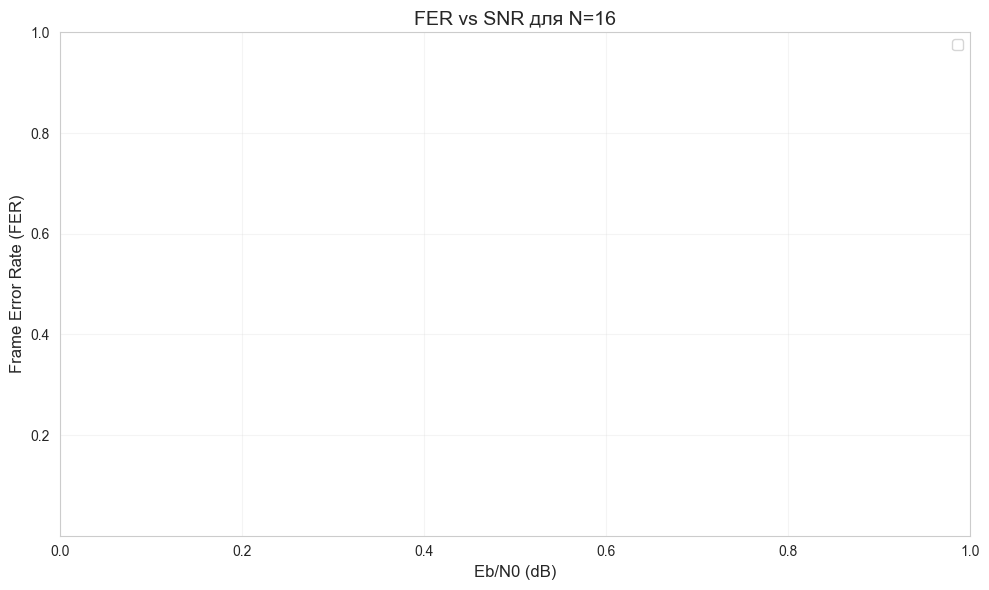

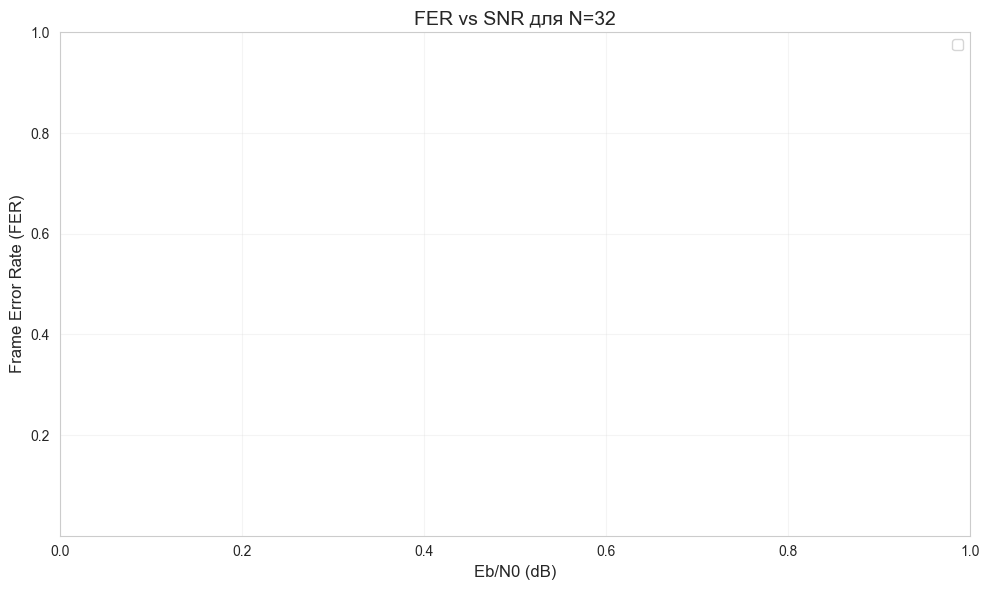

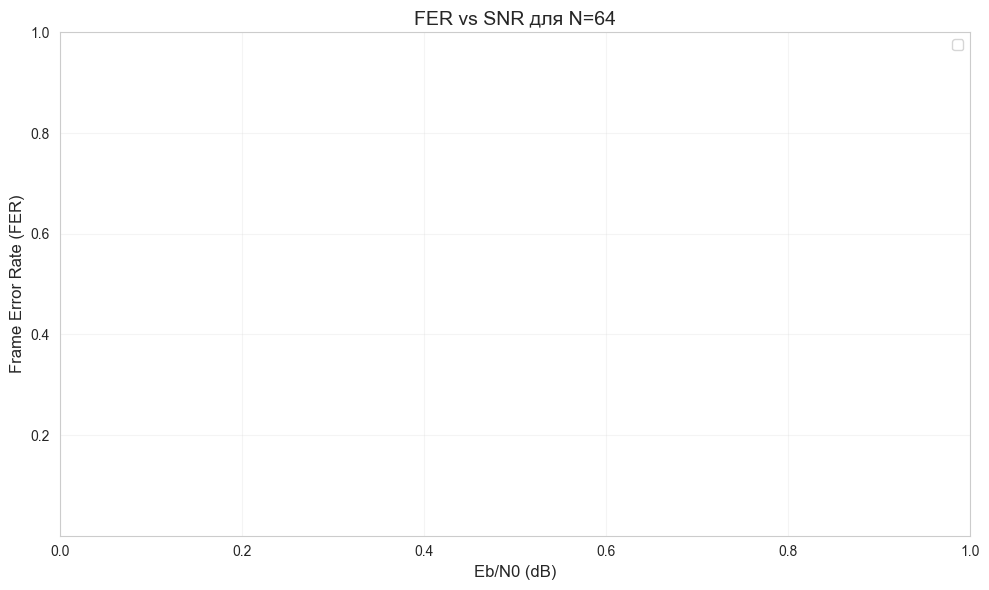


Сводка результатов:
                     FER  EbN0_dB
N  R        L                    
16 0.333333 4   0.069444        5
            8   0.104167        5
            16  0.080000        5
   0.500000 4   0.188679        5
            8   0.142857        5
            16  0.188679        5
   0.666667 4   0.232558        5
            8   0.172414        5
            16  0.153846        5
32 0.333333 4   0.072464        5
            8   0.188679        5
            16  0.112360        5
   0.500000 4   0.114943        5
            8   0.158730        5
            16  0.102041        5
   0.666667 4   0.250000        5
            8   0.277778        5
            16  0.312500        5
64 0.333333 4   0.111111        5
            8   0.109890        5
            16  0.128205        5
   0.500000 4   0.400000        5
            8   0.172414        5
            16  0.238095        5
   0.666667 4   0.370370        5
            8   0.344828        5
            16  0.312500   

In [13]:
from src.simulation import run_simulation_series, quick_test

# Выбор режима работы
print("Выберите режим работы:")
print("1 - Полная симуляция (длительно)")
print("2 - Быстрый тест (код (8,4))")
# print("3 - Тест канала (генерация и демодуляция)")

choice = input("Ваш выбор (1-2): ").strip()

if choice == "1":
    results = run_simulation_series()
    if results is not None:
        print("\nСводка результатов:")
        print(results.groupby(['N', 'R', 'L']).agg({
            'FER': 'min',
            'EbN0_dB': 'count'
        }))
elif choice == "2":
    quick_test()
else:
    print("Неверный выбор. Запуск быстрого теста...")
    quick_test()

In [ ]:
from src.simulation import run_simulation_series, quick_test

# Выбор режима работы
print("Выберите режим работы:")
print("1 - Полная симуляция (длительно)")
print("2 - Быстрый тест (код (8,4))")
# print("3 - Тест канала (генерация и демодуляция)")

choice = input("Ваш выбор (1-2): ").strip()

if choice == "1":
    results = run_simulation_series()
    if results is not None:
        print("\nСводка результатов:")
        print(results.groupby(['N', 'R', 'L']).agg({
            'FER': 'min',
            'EbN0_dB': 'count'
        }))
elif choice == "2":
    quick_test()
else:
    print("Неверный выбор. Запуск быстрого теста...")
    quick_test()

Выберите режим работы:
1 - Полная симуляция (длительно)
2 - Быстрый тест (код (8,4))
